In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
def collect_run_data(trade_name, base_dir="orbit_training_runs"):
    """
    Collect validation losses and parameters from all runs for a given trade_name.
    
    Args:
        trade_name (str): Name of the trade/experiment group.
        base_dir (str): Base directory containing run outputs.
    
    Returns:
        dict: Mapping of (n_bins, coordinate_system) to list of (val_losses, params).
    """
    trade_dir = os.path.join(base_dir, trade_name)
    if not os.path.exists(trade_dir):
        raise FileNotFoundError(f"Directory {trade_dir} does not exist.")
    
    run_data = defaultdict(list)
    
    for run_name in os.listdir(trade_dir):
        print(run_name)

        run_path = os.path.join(trade_dir, run_name)
        if not os.path.isdir(run_path):
            print("boo 1")
            continue
        
        # Load metrics.json
        sub_dir = [x for x in os.listdir(run_path) if "." not in x][0]
        metrics_path = os.path.join(run_path, sub_dir, "metrics.json")
        summary_path = os.path.join(run_path, "summary.json")
        
        if not (os.path.exists(metrics_path) and os.path.exists(summary_path)):
            print("boo 2")
            continue
        
        try:
            with open(metrics_path, 'r') as f:
                metrics = json.load(f)
            with open(summary_path, 'r') as f:
                summary = json.load(f)
            
            val_losses = metrics.get("val_losses", [])
            params = summary.get("args", {})
            
            n_bins = params.get("n_bins")
            coord_sys = params.get("coordinate_system")
            
            if n_bins is None or coord_sys is None or not val_losses:
                print("boo 3")
                continue
            
            run_data[(n_bins, coord_sys)].append((val_losses, params))
        
        except Exception as e:
            print(f"Error processing run {run_path}: {e}")
            continue
    
    return run_data

In [7]:
trade_name = "scaling_laws_v1"
run_data = collect_run_data(trade_name)        

.DS_Store
boo 1
learning_rate0.001_batch_size64_n_layers4_n_heads4_input_length32_dataset_size500_n_bins512_coordinate_systemcartesian_d_model256_d_ff1024
learning_rate1e-05_batch_size32_n_layers4_n_heads4_input_length32_dataset_size100_n_bins8192_coordinate_systemspherical_d_model256_d_ff1024
boo 2


In [8]:
run_data

defaultdict(list,
            {(512,
              'cartesian'): [([1.1253978016835138,
                0.9054382007527617,
                0.7890979347362617,
                0.7115412151680842,
                0.6647634865606532,
                0.6202448258836811,
                0.5901901790182238,
                0.5670764890095198,
                5.362951767463563,
                5.225292611956028],
               {'trade_name': 'scaling_laws_v1',
                'learning_rate': 0.001,
                'batch_size': 64,
                'n_layers': 4,
                'n_heads': 4,
                'input_length': 32,
                'dataset_size': 500,
                'n_bins': 512,
                'coordinate_system': 'cartesian',
                'd_model': 256,
                'd_ff': 1024,
                'epochs': 10})]})

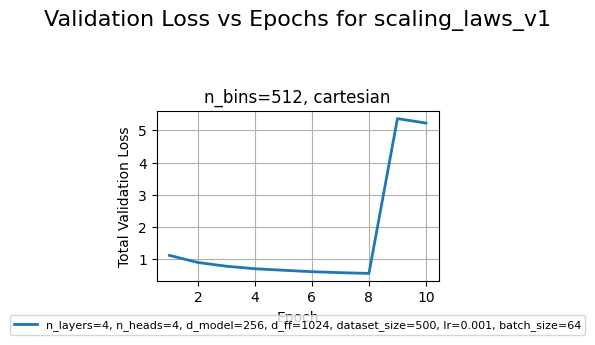

In [11]:
# Determine the number of subplots needed
combinations = sorted(run_data.keys())  # Sort for consistent ordering
n_plots = len(combinations)

# Calculate grid size (e.g., aim for a roughly square grid)
n_cols = int(np.ceil(np.sqrt(n_plots)))
n_rows = int(np.ceil(n_plots / n_cols))

# Create a single figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False)
axes = axes.flatten()  # Flatten to easily index axes

for idx, (n_bins, coord_sys) in enumerate(combinations):
    ax = axes[idx]
    runs = run_data[(n_bins, coord_sys)]
    
    for val_losses, params in runs:
        epochs = list(range(1, len(val_losses) + 1))
        
        # Create legend label with relevant parameters
        legend_label = (
            f"n_layers={params['n_layers']}, "
            f"n_heads={params['n_heads']}, "
            f"d_model={params['d_model']}, "
            f"d_ff={params['d_ff']}, "
            f"dataset_size={params['dataset_size']}, "
            f"lr={params['learning_rate']}, "
            f"batch_size={params['batch_size']}"
        )
        
        ax.plot(epochs, val_losses, label=legend_label, linewidth=2)
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Total Validation Loss")
    ax.set_title(f"n_bins={n_bins}, {coord_sys}")
    ax.grid(True)
    
    # Place legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize=8, 
                ncol=2, borderaxespad=0.)

for idx in range(len(combinations), len(axes)):
    axes[idx].set_visible(False)



fig.suptitle(f"Validation Loss vs Epochs for {trade_name}", fontsize=16, y=1.02)

# plt.tight_layout()

# Adjust layout to prevent overlap, leaving space for legends
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave bottom space for legends

plt.show()